In [1]:
import os
import random
import numpy as np # linear algebra
from PIL import Image, ImageEnhance, ImageOps
import cv2
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.random import set_seed
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Input, Conv2D, ELU, BatchNormalization,concatenate, \
                                    Add, GlobalAveragePooling2D, Flatten, Dense, MaxPooling2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model, load_model
import matplotlib
from matplotlib import pyplot as plt

In [2]:
radom_seed = 0
random.seed(radom_seed)
numpy_seed = 0
np.random.seed(numpy_seed)
tensorflow_seed = 0
set_seed(tensorflow_seed)

In [3]:
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, N_CLASSES = 256,256,3,9
BASE_DIR = os.path.abspath(os.path.dirname("__file__"))
INPUT_DIR = os.path.join(BASE_DIR, "data", "NA_Fish_Dataset")
SAVE_DIRECTORY = os.path.join(BASE_DIR, "data", "numpy_data")
MODEL_DIR = os.path.join(BASE_DIR, "model_files")
MODEL_PATH = os.path.join(MODEL_DIR, "model_resent.h5")

In [4]:
classes_to_labels = dict(zip(list(os.walk(INPUT_DIR))[0][1], [i for i in range(10)]))
labels_to_classes = dict(zip([i for i in range(10)], list(os.walk(INPUT_DIR))[0][1]))

In [5]:
X_train = np.load(os.path.join(SAVE_DIRECTORY, "X_train.npy"))
X_valid = np.load(os.path.join(SAVE_DIRECTORY, "X_valid.npy"))
Y_train = np.load(os.path.join(SAVE_DIRECTORY, "Y_train.npy"))
Y_valid = np.load(os.path.join(SAVE_DIRECTORY, "Y_valid.npy"))

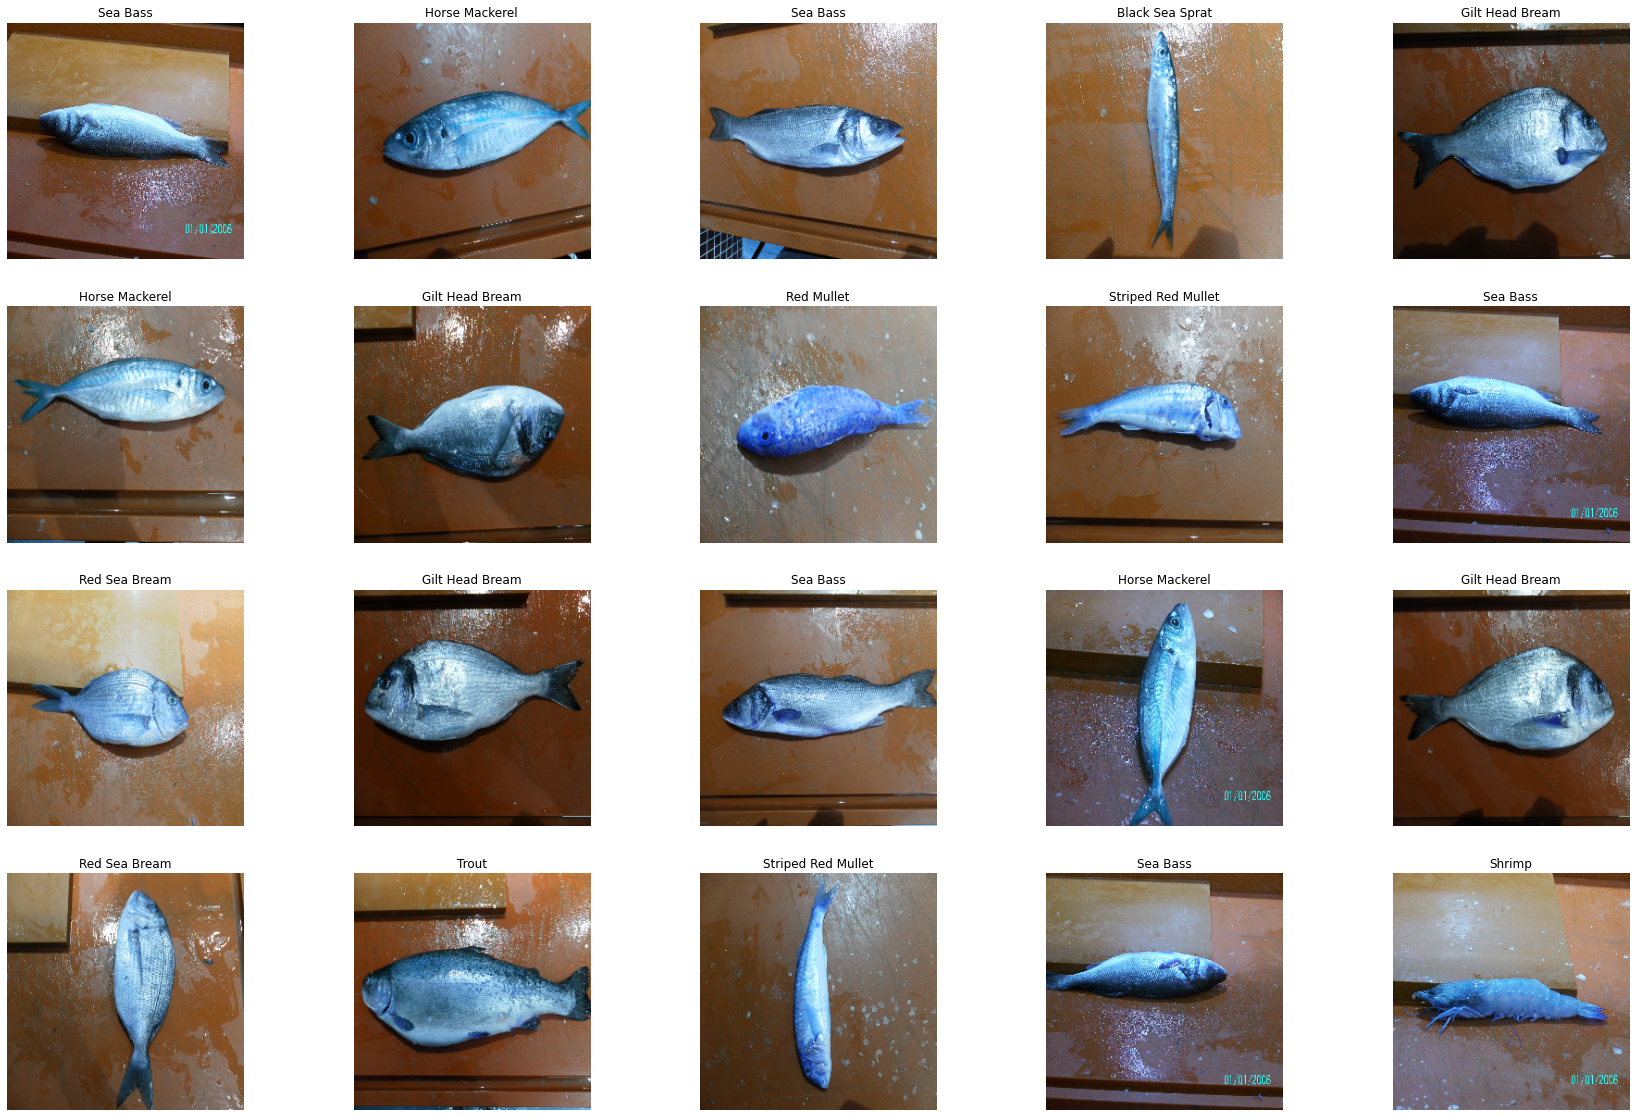

In [6]:
matplotlib.rcParams['figure.figsize'] = (30.0, 20.0)
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.title(labels_to_classes[Y_valid[i]])
    plt.imshow(X_valid[i])
    plt.axis('off')
plt.show()

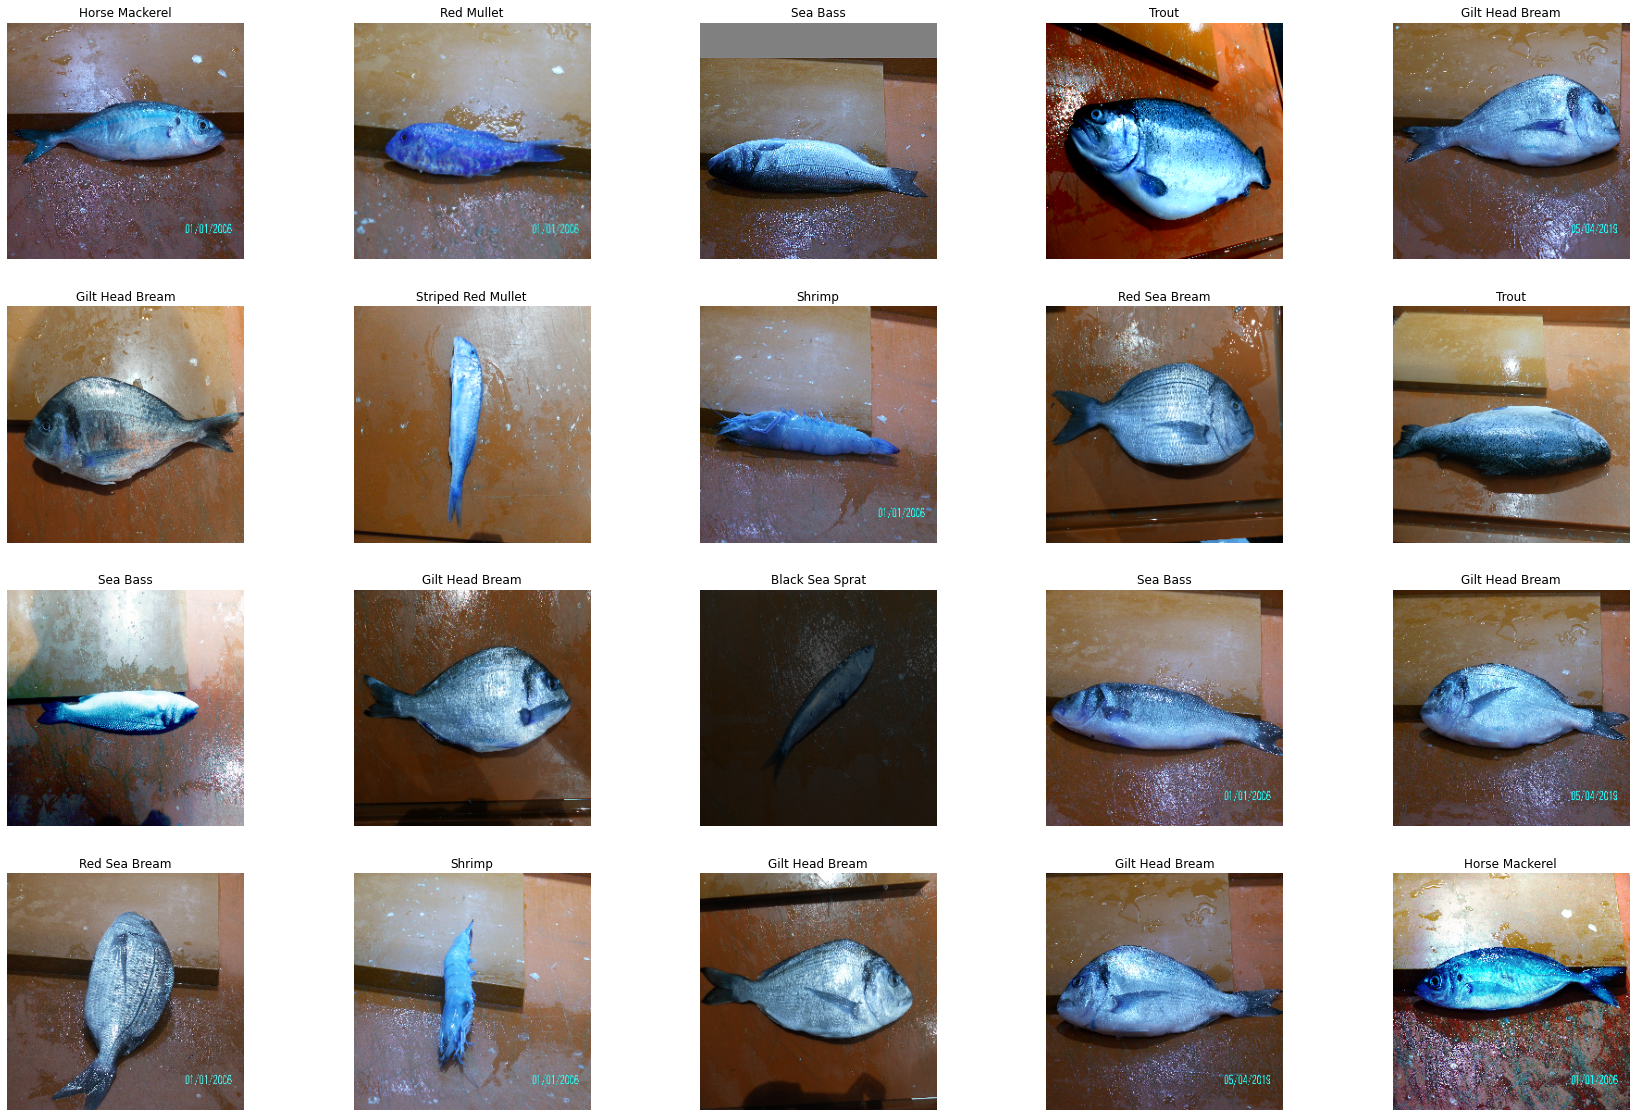

In [7]:
matplotlib.rcParams['figure.figsize'] = (30.0, 20.0)
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.title(labels_to_classes[Y_train[i]])
    plt.imshow(X_train[i])
    plt.axis('off')
plt.show()

In [8]:
def elu_bn(x):
    """
    A function for computing elu then batch normalization
    x - input tensor
    bn - ouput tensor after elu and bn
    """
    elu = ELU()(x)
    bn = BatchNormalization()(elu)
    return bn

def residual_block(x, num_filters, kernel_size):
    """
    A function to create residual block
    x - input tensor
    num_filters - number of filters
    kernel_size - size of kernel
    out - output tensor
    """
    x2 = Conv2D(kernel_size=kernel_size,
               strides= 1,
               filters=num_filters,
               padding="same")(x)
    x2 = elu_bn(x2)
    y = Conv2D(kernel_size=kernel_size,
               strides= 1,
               filters=num_filters,
               padding="same")(x2)
    y = elu_bn(y)
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=num_filters,
               padding="same")(y)
    out = Add()([x2, y])
    out = elu_bn(out)
    return out

def create_net(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, N_CLASSES,
               filters, kernels, learning_rate):
    """
    A function to create resnet
    filters - list containing filter size at successive conv layer
    kernels - list containing kernel size at successive conv layer
    model - keras model object
    """
    X = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    n_layers = len(kernels)
    for i in range(n_layers):
        if i ==0:
            layer = residual_block(X, filters[i], kernels[i])
            layer = MaxPooling2D((2,2), strides=(2,2), padding='same')(layer)
        elif i == n_layers-1:
            layer = residual_block(layer, filters[i], kernels[i])
        else:
            layer = residual_block(layer, filters[i], kernels[i])
            layer = MaxPooling2D((2,2), strides=(2,2), padding='same')(layer)

    Y = GlobalAveragePooling2D()(layer)
    Y = Dense(128, activation='elu')(Y)
    Y = BatchNormalization()(Y)
    Y = Dense(N_CLASSES, activation='softmax')(Y)

    model = Model(inputs=X, outputs=Y)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss=SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model

In [9]:
clear_session()
num_filters = 64
kernels = [3,3,3,3]
filters = [16,16,32,32]
learning_rate = (1e-3)*0.25
model = create_net(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, N_CLASSES,
                   filters, kernels, learning_rate)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
elu (ELU)                       (None, 256, 256, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          elu[0][0]                        
______________________________________________________________________________________________

In [10]:
def train_model(model, epochs, batch_size, checkpoint_cb, 
                X_train, Y_train, X_valid, Y_valid):
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size = batch_size,
                        validation_data = (X_valid, Y_valid), 
                        callbacks=[checkpoint_cb])
    return model, history

In [11]:
epochs = 300
batch_size = 100
checkpoint_cb = ModelCheckpoint(MODEL_PATH, monitor = 'val_accuracy', 
                                save_freq = "epoch", save_best_only=True, 
                                mode = "max")
model, history = train_model(model, epochs, batch_size, checkpoint_cb, 
                             X_train, Y_train, X_valid, Y_valid)

Epoch 1/300
8/8 [==============================] - 7s 854ms/step - loss: 2.1766 - accuracy: 0.2391 - val_loss: 2.1943 - val_accuracy: 0.0938
Epoch 2/300
8/8 [==============================] - 5s 626ms/step - loss: 1.8332 - accuracy: 0.3552 - val_loss: 2.1881 - val_accuracy: 0.0938
Epoch 3/300
8/8 [==============================] - 5s 631ms/step - loss: 1.6410 - accuracy: 0.4495 - val_loss: 2.1939 - val_accuracy: 0.0938
Epoch 4/300
8/8 [==============================] - 5s 627ms/step - loss: 1.5516 - accuracy: 0.4645 - val_loss: 2.1998 - val_accuracy: 0.0938
Epoch 5/300
8/8 [==============================] - 5s 610ms/step - loss: 1.4577 - accuracy: 0.5096 - val_loss: 2.2148 - val_accuracy: 0.0938
Epoch 6/300
8/8 [==============================] - 5s 613ms/step - loss: 1.3675 - accuracy: 0.5437 - val_loss: 2.1912 - val_accuracy: 0.0938
Epoch 7/300
8/8 [==============================] - 5s 627ms/step - loss: 1.3315 - accuracy: 0.5833 - val_loss: 2.1925 - val_accuracy: 0.1094
Epoch 8/300
8

Epoch 59/300
8/8 [==============================] - 5s 649ms/step - loss: 0.1869 - accuracy: 0.9617 - val_loss: 1.1909 - val_accuracy: 0.5469
Epoch 60/300
8/8 [==============================] - 5s 657ms/step - loss: 0.2136 - accuracy: 0.9590 - val_loss: 1.1370 - val_accuracy: 0.6250
Epoch 61/300
8/8 [==============================] - 5s 638ms/step - loss: 0.1936 - accuracy: 0.9577 - val_loss: 0.9786 - val_accuracy: 0.6719
Epoch 62/300
8/8 [==============================] - 5s 660ms/step - loss: 0.2123 - accuracy: 0.9563 - val_loss: 0.9230 - val_accuracy: 0.6719
Epoch 63/300
8/8 [==============================] - 5s 655ms/step - loss: 0.2357 - accuracy: 0.9358 - val_loss: 1.0354 - val_accuracy: 0.6250
Epoch 64/300
8/8 [==============================] - 5s 641ms/step - loss: 0.2012 - accuracy: 0.9563 - val_loss: 0.8757 - val_accuracy: 0.6719
Epoch 65/300
8/8 [==============================] - 5s 668ms/step - loss: 0.1997 - accuracy: 0.9536 - val_loss: 1.0706 - val_accuracy: 0.7031
Epoch 

8/8 [==============================] - 5s 660ms/step - loss: 0.1102 - accuracy: 0.9768 - val_loss: 0.2612 - val_accuracy: 0.9062
Epoch 117/300
8/8 [==============================] - 5s 636ms/step - loss: 0.0954 - accuracy: 0.9836 - val_loss: 0.2748 - val_accuracy: 0.8906
Epoch 118/300
8/8 [==============================] - 5s 656ms/step - loss: 0.0833 - accuracy: 0.9850 - val_loss: 0.1791 - val_accuracy: 0.9531
Epoch 119/300
8/8 [==============================] - 5s 641ms/step - loss: 0.0885 - accuracy: 0.9822 - val_loss: 0.2071 - val_accuracy: 0.9375
Epoch 120/300
8/8 [==============================] - 5s 640ms/step - loss: 0.0670 - accuracy: 0.9863 - val_loss: 0.2497 - val_accuracy: 0.8906
Epoch 121/300
8/8 [==============================] - 5s 638ms/step - loss: 0.0694 - accuracy: 0.9891 - val_loss: 0.2168 - val_accuracy: 0.9219
Epoch 122/300
8/8 [==============================] - 5s 640ms/step - loss: 0.0719 - accuracy: 0.9850 - val_loss: 0.2341 - val_accuracy: 0.8906
Epoch 123/300

8/8 [==============================] - 5s 629ms/step - loss: 0.0444 - accuracy: 0.9877 - val_loss: 0.3089 - val_accuracy: 0.9375
Epoch 174/300
8/8 [==============================] - 5s 630ms/step - loss: 0.0415 - accuracy: 0.9891 - val_loss: 0.2101 - val_accuracy: 0.9375
Epoch 175/300
8/8 [==============================] - 5s 636ms/step - loss: 0.0395 - accuracy: 0.9918 - val_loss: 0.2682 - val_accuracy: 0.9375
Epoch 176/300
8/8 [==============================] - 5s 653ms/step - loss: 0.0476 - accuracy: 0.9863 - val_loss: 0.2965 - val_accuracy: 0.9219
Epoch 177/300
8/8 [==============================] - 5s 650ms/step - loss: 0.0612 - accuracy: 0.9863 - val_loss: 0.2630 - val_accuracy: 0.9062
Epoch 178/300
8/8 [==============================] - 5s 623ms/step - loss: 0.0949 - accuracy: 0.9809 - val_loss: 0.6513 - val_accuracy: 0.8438
Epoch 179/300
8/8 [==============================] - 5s 653ms/step - loss: 0.0933 - accuracy: 0.9754 - val_loss: 0.8479 - val_accuracy: 0.7188
Epoch 180/300

8/8 [==============================] - 5s 654ms/step - loss: 0.0441 - accuracy: 0.9918 - val_loss: 0.2121 - val_accuracy: 0.9062
Epoch 231/300
8/8 [==============================] - 5s 645ms/step - loss: 0.0353 - accuracy: 0.9932 - val_loss: 0.3309 - val_accuracy: 0.8906
Epoch 232/300
8/8 [==============================] - 5s 648ms/step - loss: 0.0347 - accuracy: 0.9904 - val_loss: 0.3570 - val_accuracy: 0.8594
Epoch 233/300
8/8 [==============================] - 5s 646ms/step - loss: 0.0364 - accuracy: 0.9918 - val_loss: 0.2654 - val_accuracy: 0.9219
Epoch 234/300
8/8 [==============================] - 5s 649ms/step - loss: 0.0282 - accuracy: 0.9932 - val_loss: 0.2480 - val_accuracy: 0.9062
Epoch 235/300
8/8 [==============================] - 5s 637ms/step - loss: 0.0327 - accuracy: 0.9918 - val_loss: 0.3193 - val_accuracy: 0.9062
Epoch 236/300
8/8 [==============================] - 5s 659ms/step - loss: 0.0395 - accuracy: 0.9904 - val_loss: 0.5043 - val_accuracy: 0.8125
Epoch 237/300

8/8 [==============================] - 5s 646ms/step - loss: 0.0347 - accuracy: 0.9904 - val_loss: 0.3912 - val_accuracy: 0.8750
Epoch 288/300
8/8 [==============================] - 5s 641ms/step - loss: 0.0315 - accuracy: 0.9918 - val_loss: 0.3783 - val_accuracy: 0.9062
Epoch 289/300
8/8 [==============================] - 5s 650ms/step - loss: 0.0354 - accuracy: 0.9836 - val_loss: 0.2309 - val_accuracy: 0.9219
Epoch 290/300
8/8 [==============================] - 5s 647ms/step - loss: 0.0482 - accuracy: 0.9918 - val_loss: 0.3798 - val_accuracy: 0.9062
Epoch 291/300
8/8 [==============================] - 5s 660ms/step - loss: 0.0392 - accuracy: 0.9877 - val_loss: 0.3076 - val_accuracy: 0.9375
Epoch 292/300
8/8 [==============================] - 5s 644ms/step - loss: 0.0367 - accuracy: 0.9891 - val_loss: 0.3744 - val_accuracy: 0.9219
Epoch 293/300
8/8 [==============================] - 5s 654ms/step - loss: 0.0330 - accuracy: 0.9877 - val_loss: 0.2021 - val_accuracy: 0.9219
Epoch 294/300

In [12]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

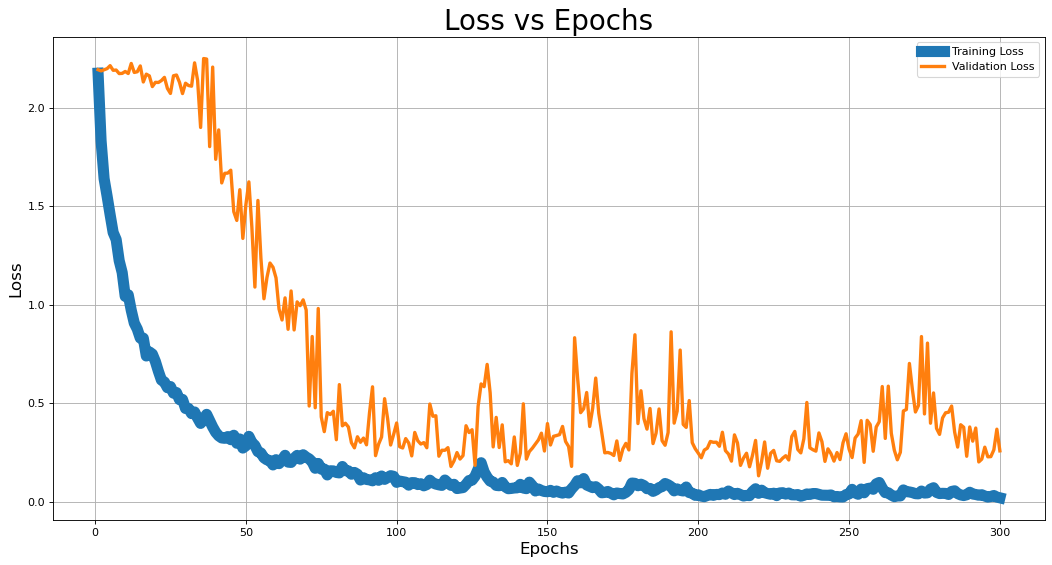

In [13]:
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss,  label='Training Loss', linewidth = 10.0)
plt.plot(epochs, val_loss,  label='Validation Loss', linewidth = 3)
plt.title('Loss vs Epochs', fontsize = 25)
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.legend()
plt.grid(True)
plt.show()

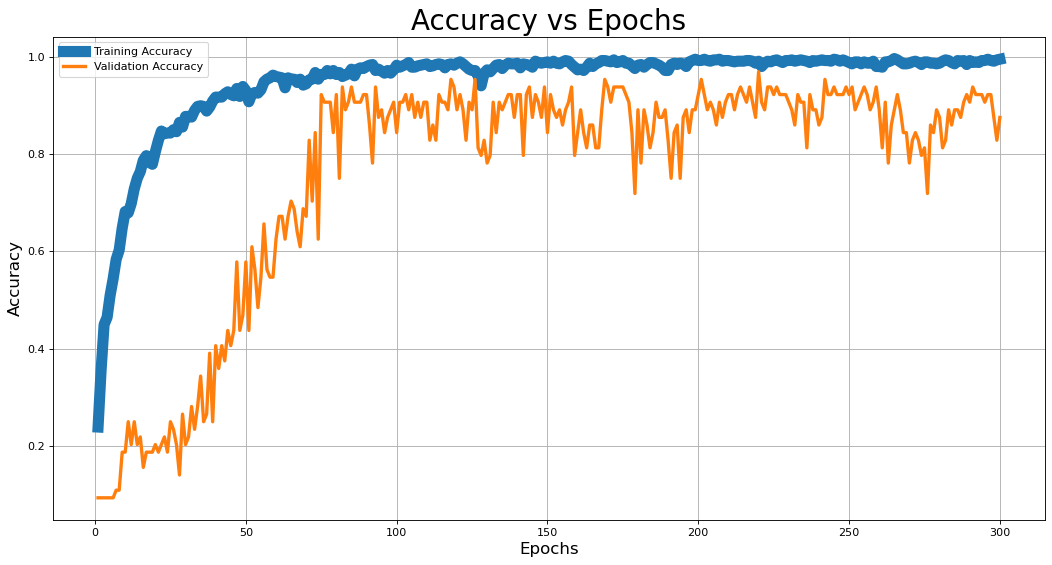

In [14]:
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc,  label='Training Accuracy', linewidth = 10.0)
plt.plot(epochs, val_acc,  label='Validation Accuracy', linewidth = 3)
plt.title('Accuracy vs Epochs', fontsize = 25)
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.legend()
plt.grid(True)
plt.show()

In [15]:
model = load_model(MODEL_PATH)
valid_accuracy = round(accuracy_score(Y_valid, np.argmax(model.predict(X_valid), axis = -1)),2)
print("Valid accuracy:",valid_accuracy)

Valid accuracy: 0.97
